# LUSD Pool Model

In [74]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as md
from matplotlib import ticker
import scipy as scp
import scipy.optimize as opt
import csv
import math
import random
import pandas as pd
import copy
from datetime import datetime, timedelta
import pytz

## Core Idea
The core idea of a pool is a LUSD : staBAL pool, which utilizes StableSwap invariant and provides low slippage tool for swapping tokens equal in price (as LUSD and staBAL are both close to 1\\$: LUSD = 1.01\\$ and staBAL = 0.99$). staBAL is a BPT token of Balancer stable pool with 3 stable tokens: USDC, USDT and DAI.

Such pool has a potential to be a high-profitable mining/income tool. That is because Balacner architecture allows to stake liquidity tokens of the pool into other pools and investing mechanisms, though still maintaining the pool as if all the tokens still remain in the pool. In other words, LUSD tokens from the pool could be staked into Liquidity Stability Pool for additional profit (with some reserve left in the original pool to maintain small swaps) and perform liquidity mining for the liquidity providers of the original pool. This profits will sum with the conventional profits from swap fees and liquidity provision in the original pool, effectively adding APRs. At the time of the document creation, expected APR of Liquity Stability Pool staking is ~13%.

# Pool Model Based on Previous Data

For LUSD part of the Pool, we take the existing data on operation of *Liquity* protocol from July 1st, 2021 to September 9th, 2021. The pool acts as if "it has always been there".

### LUSD operations

* LQTY rewards are calculated based on the Pool's share of LUSD in the Stability Pool. The amount of LQTY rewards is calculated as follows:

$$
\begin{align*}
& SP_{share} = \frac{LUSD_{Pool}^{i}}{LUSD_{StabilityPool}^{i}};\\
\\
& LQTY_{gained}^{i} = (LQTY_{total}^{i} - LQTY_{total}^{i-1})\times SP_{share},
\end{align*}
$$

where upper index $i$ denotes the timestamp of the calculation. The timestamps are exactly 1 hour difference, except the events of liquidations.

* Liquidation rewards are calculated basically the same way, taking into consideration the mathematics behind the collateral distibution and LUSD burning.

$$
\begin{align*}
& COL_{distributed}^{i} = COL_{liquidated}^{i}\times(1 - 0.05)\cdot100\%;\\
\\
& COL_{gained}^{i} = COL_{distributed}^{i}\times SP_{share}^{i};\\
\\
& LUSD_{lost}^{i} = LUSD_{burned}^{i}\times SP_{share}^{i}.
\end{align*}
$$

* Trades of LQTY token occur when a minimum resonable amount is collected in the Pool. It is almost impossible to account for slippage and trading fees, thus every trading operation is multiplyed by loss coefficient:

$$
\begin{align*}
& LUSD_{bought}^{i} = \frac{LQTY_{sold}^{i}\times{LQTY_price}^{i}}{LUSD_{price}^{i}}\times L; \hspace{3mm} L = 0.9
\end{align*}
$$

### staBAL operations

Due to lack of the data on staBAL, following assumptions have been made:

* staBAL price rises linearly at a rate of 1% per year from initial start at 1\$:

$$
staBAL_{price}^{i} = staBAL_{price}^{i-1}\cdot \frac{(1 + 0.01)}{365\times 24}
$$

* staBAL APR for BAL rewards is roughly estimated at 7\%.

* BAL prices have been obtained. The logic of selling BAL tokens for staBAL is the same as for LQTY tokens.

### Pool Initial data

We start as a Pool of 50/50 LUSD/staBAL.

* $TVL = \$ 60M$

### Creating Dataframes of Different Statistics

##### Opening files

In [105]:
Total_LUSD_Supply = pd.read_csv('new_data/tmp/Total LUSD Supply.csv')
LUSD_Utilization = pd.read_csv('new_data/tmp/LUSD Utilization.csv')
Total_LQTY_Staked = pd.read_csv('new_data/tmp/Total LQTY Staked.csv')
Liquidations_ = pd.read_csv('new_data/tmp/Recent Liquidations.csv')
Redeems_ = pd.read_csv('new_data/tmp/Recently Redeemed Troves.csv')
staBAL_ = pd.read_csv('new_data/tmp/staBAL Revenue.csv')
staBAL_Supply_ = pd.read_csv('new_data/tmp/staBAL Total Supply.csv')

In [153]:
start_date = datetime(2021, 10, 1, 0, 0, 0) #1th of October, 2021, 00:00
start_date = pd.to_datetime(start_date, utc=True)

end_date = datetime(2021, 12, 25, 0, 0, 0) #1st of January, 2022, 00:00
end_date = pd.to_datetime(end_date, utc=True)

dateColumn = pd.date_range(start_date, end_date, freq='H')
dateColumn = pd.DataFrame(dateColumn, columns=['date',])
dateColumn

,date
0,2021-10-01 00:00:00+00:00
1,2021-10-01 01:00:00+00:00
2,2021-10-01 02:00:00+00:00
3,2021-10-01 03:00:00+00:00
4,2021-10-01 04:00:00+00:00
...,...
2036,2021-12-24 20:00:00+00:00
2037,2021-12-24 21:00:00+00:00
2038,2021-12-24 22:00:00+00:00
2039,2021-12-24 23:00:00+00:00


##### Creating LUSD dataframe

In [154]:
Total_LUSD_Supply = pd.read_csv('new_data/tmp/Total LUSD Supply.csv')
LUSD_Utilization = pd.read_csv('new_data/tmp/LUSD Utilization.csv')
LUSD = pd.DataFrame()

LUSD['date'] = pd.to_datetime(LUSD_Utilization['hour'])
LUSD['LUSD in SP'] = LUSD_Utilization['stabilityPool']
#LUSD['LUSD other'] = LUSD_Utilization.iloc[:, 1:].sum(1, numeric_only=True) - LUSD_Utilization['stabilityPool']

LUSD = LUSD.merge(right=dateColumn, on='date', how='right')

LUSD.head()

,date,LUSD in SP
0,2021-10-01 00:00:00+00:00,4.761356e+08
1,2021-10-01 01:00:00+00:00,4.761356e+08
2,2021-10-01 02:00:00+00:00,4.761356e+08
3,2021-10-01 03:00:00+00:00,4.761891e+08
4,2021-10-01 04:00:00+00:00,4.761891e+08


##### Creating LQTY dataframe

In [155]:
LQTY = pd.DataFrame()

LQTY['date'] = pd.to_datetime(Total_LQTY_Staked['hour'])
LQTY['LQTY staked'] = Total_LQTY_Staked['totalLQTYStaked']
LQTY['LQTY circulating'] = Total_LQTY_Staked['totalLQTYClaimed'] - Total_LQTY_Staked['totalLQTYStaked']
LQTY['LQTY total'] = Total_LQTY_Staked['totalLQTYClaimed']

LQTY = LQTY.merge(right=dateColumn, on='date', how='right')
LQTY = LQTY.fillna(method='bfill')
    
LQTY

,date,LQTY staked,LQTY circulating,LQTY total
0,2021-10-01 00:00:00+00:00,8.882722e+06,1.432107e+06,1.031483e+07
1,2021-10-01 01:00:00+00:00,8.883722e+06,1.431107e+06,1.031483e+07
2,2021-10-01 02:00:00+00:00,8.883722e+06,1.431107e+06,1.031483e+07
3,2021-10-01 03:00:00+00:00,8.884150e+06,1.432151e+06,1.031517e+07
4,2021-10-01 04:00:00+00:00,8.884150e+06,1.432151e+06,1.031563e+07
...,...,...,...,...
2036,2021-12-24 20:00:00+00:00,1.145215e+07,2.121214e+06,1.357336e+07
2037,2021-12-24 21:00:00+00:00,1.148139e+07,2.092846e+06,1.357424e+07
2038,2021-12-24 22:00:00+00:00,1.148139e+07,2.092846e+06,1.357424e+07
2039,2021-12-24 23:00:00+00:00,1.148202e+07,2.095845e+06,1.357787e+07


##### Creating Liquidations dataframe

In [156]:
Liquidations = pd.DataFrame()

Liquidations['date'] = pd.to_datetime(Liquidations_['timestamp'])
Liquidations['LIQ col'] = Liquidations_['collateral']
Liquidations['LIQ debt'] = Liquidations_['debt']
Liquidations['LIQ price'] = Liquidations_['price']
Liquidations['LIQ CR'] = Liquidations_['collateralRatio']
Liquidations['LIQ mode'] = Liquidations_['mode']
        
Liquidations = Liquidations[(Liquidations['date'] >= start_date) & (Liquidations['date'] <= end_date)].merge(right=dateColumn, on='date', how='outer')
#Liquidations = Liquidations.merge(right=dateColumn, on='date', how='outer')
Liquidations.sort_values(by='date', ignore_index=True, inplace=True)
Liquidations.loc[:, 'LIQ col':'LIQ CR'] = Liquidations.loc[:, 'LIQ col':'LIQ CR'].fillna(value=0)
Liquidations.loc[:, 'LIQ mode'] = Liquidations.loc[:, 'LIQ mode'].fillna(value = 'none')

Liquidations.head()

,date,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode
0,2021-10-01 00:00:00+00:00,0.0,0.0,0.0,0.0,none
1,2021-10-01 01:00:00+00:00,0.0,0.0,0.0,0.0,none
2,2021-10-01 02:00:00+00:00,0.0,0.0,0.0,0.0,none
3,2021-10-01 03:00:00+00:00,0.0,0.0,0.0,0.0,none
4,2021-10-01 04:00:00+00:00,0.0,0.0,0.0,0.0,none


##### Creating Redemption dataframe

In [157]:
Redeems = pd.DataFrame()

Redeems['date'] = pd.to_datetime(Redeems_['timestamp'])
Redeems['col'] = Redeems_['collateral']
Redeems['debt'] = Redeems_['debt']
Redeems['price'] = Redeems_['price']
Redeems['CR'] = Redeems_['collateralRatio']
Redeems['ETH Redeemed'] = Redeems_['ethRedeemed']
Redeems['LUSD Redeemed'] = Redeems_['lusdRedeemed']

Redeems = Redeems[(Redeems['date'] >= start_date) & (Redeems['date'] <= end_date)].merge(right=dateColumn, on='date', how='outer')
Redeems.sort_values(by='date', ignore_index=True, inplace=True)
Redeems.fillna(value=0, inplace=True)

Redeems

,date,col,debt,price,CR,ETH Redeemed,LUSD Redeemed
0,2021-10-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-10-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-10-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-10-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2251,2021-12-24 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2252,2021-12-24 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2253,2021-12-24 22:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2254,2021-12-24 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0


##### Loading staBAL Data

In [297]:
staBAL_Revenue = pd.read_csv('new_data/tmp/staBAL Revenue.csv')
staBAL_Supply = pd.read_csv('new_data/tmp/staBAL Total Supply.csv')
staBAL_Rewards = pd.read_csv('new_data/tmp/staBAL Rewards2.csv')

staBAL = pd.DataFrame()

staBAL['day'] = dateColumn
staBAL_Supply['day'] = pd.to_datetime(staBAL_Supply['day'])
staBAL_Revenue['day'] = pd.to_datetime(staBAL_Revenue['day'])
staBAL_Rewards['week'] = pd.to_datetime(staBAL_Rewards['week'], utc=True)
staBAL_Rewards = staBAL_Rewards.rename(columns={'week':'day'}).drop(columns=['revenues'])

staBAL = staBAL.merge(right=staBAL_Supply, how='outer', on='day')
staBAL = staBAL.merge(right=staBAL_Rewards, how='outer', on='day')
staBAL = staBAL.merge(right=staBAL_Revenue, how='outer', on='day')

staBAL = staBAL.rename(columns={'day': 'date',
                                'revenues':'staBAL Revenue',
                                'daily_total_supply':'staBAL Total Supply',
                                'revenues_ratio':'staBAL Rewards',
                                'amount':'BAL reward'})
staBAL = staBAL.drop(columns=['cumulative_revenues', 'volume', 'volume_ratio'])

staBAL = staBAL[(staBAL['date'] >= start_date) & (staBAL['date'] <= end_date)].sort_values(by='date')

staBAL['staBAL Rewards'] = staBAL['staBAL Rewards'].fillna(value=0)
staBAL['BAL reward'] = staBAL['BAL reward'].fillna(value=0)
staBAL = staBAL.fillna(method='ffill').fillna(method='bfill')

staBAL

,date,staBAL Total Supply,BAL reward,staBAL Rewards,staBAL Revenue
0,2021-10-01 00:00:00+00:00,1.533193e+08,0.0,0.0,31.035312
1,2021-10-01 01:00:00+00:00,1.533193e+08,0.0,0.0,1.862577
2,2021-10-01 02:00:00+00:00,1.533193e+08,0.0,0.0,4.158515
3,2021-10-01 03:00:00+00:00,1.533073e+08,0.0,0.0,2.169245
4,2021-10-01 04:00:00+00:00,1.533073e+08,0.0,0.0,220.101656
...,...,...,...,...,...
2036,2021-12-24 20:00:00+00:00,1.476815e+08,0.0,0.0,29.619575
2037,2021-12-24 21:00:00+00:00,1.476815e+08,0.0,0.0,29.619575
2038,2021-12-24 22:00:00+00:00,1.476815e+08,0.0,0.0,113.974513
2039,2021-12-24 23:00:00+00:00,1.476815e+08,0.0,0.0,113.974513


## Loading Prices

##### Loading ETH price

In [227]:
ETHprice = pd.read_csv('./new_data/ETH price.csv')
ETHprice.drop(ETHprice.loc[:, ['market_cap', 'total_volume']], axis=1, inplace=True)
ETHprice['snapped_at'] = pd.to_datetime(ETHprice['snapped_at'], utc=True )
ETHprice = ETHprice.sort_values(by='snapped_at', ascending=True, ignore_index=True)
ETHprice.rename(columns = {'snapped_at':'date', 'price':'ETH price'}, inplace=True)
ETHprice = ETHprice.merge(right=dateColumn, how='outer')
ETHprice = ETHprice[(ETHprice['date'] >= start_date) & (ETHprice['date'] <= end_date)].sort_values(by='date').reset_index(drop=True).fillna(method='ffill')
ETHprice

,date,ETH price
0,2021-10-01 00:00:00+00:00,3013.493232
1,2021-10-01 01:00:00+00:00,3013.493232
2,2021-10-01 02:00:00+00:00,3013.493232
3,2021-10-01 03:00:00+00:00,3013.493232
4,2021-10-01 04:00:00+00:00,3013.493232
...,...,...
2036,2021-12-24 20:00:00+00:00,4113.529932
2037,2021-12-24 21:00:00+00:00,4113.529932
2038,2021-12-24 22:00:00+00:00,4113.529932
2039,2021-12-24 23:00:00+00:00,4113.529932


##### Loading BAL price

In [229]:
BALprice = pd.read_csv('./new_data/BAL price.csv')
BALprice = BALprice.loc[:, ('snapped_at', 'price')].rename(columns={'snapped_at': 'date', 'price':'BAL price'})
BALprice.loc[:, 'date'] = pd.to_datetime(BALprice['date'])
BALprice = BALprice.merge(right=dateColumn, how='outer', on='date')
BALprice = BALprice.sort_values(by='date', ignore_index=True)
BALprice = BALprice[(BALprice['date'] >= start_date) & (BALprice['date'] <= end_date)].fillna(method='ffill')
BALprice = BALprice.reset_index(drop=True)
BALprice

,date,BAL price
0,2021-10-01 00:00:00+00:00,19.748189
1,2021-10-01 01:00:00+00:00,19.748189
2,2021-10-01 02:00:00+00:00,19.748189
3,2021-10-01 03:00:00+00:00,19.748189
4,2021-10-01 04:00:00+00:00,19.748189
...,...,...
2036,2021-12-24 20:00:00+00:00,19.181731
2037,2021-12-24 21:00:00+00:00,19.181731
2038,2021-12-24 22:00:00+00:00,19.181731
2039,2021-12-24 23:00:00+00:00,19.181731


##### LOading LQTY Price

In [264]:
LQTYprice = pd.read_csv('./new_data/tmp/LQTY Price.csv')
LQTYprice = LQTYprice.loc[:, ('snapped_at', 'price')].rename(columns={'snapped_at':'date', 'price':'LQTY Price'})
LQTYprice['date'] = pd.to_datetime(LQTYprice['date'])
LQTYprice = LQTYprice.merge(right=dateColumn, how='outer', on='date')
LQTYprice = LQTYprice.sort_values(by='date', ignore_index=True)
LQTYprice = LQTYprice[(LQTYprice['date'] >= start_date) & (LQTYprice['date'] <= end_date)].fillna(method='ffill')
LQTYprice = LQTYprice.reset_index(drop=True)
LQTYprice

,date,LQTY Price
0,2021-10-01 00:00:00+00:00,4.713073
1,2021-10-01 01:00:00+00:00,4.713073
2,2021-10-01 02:00:00+00:00,4.713073
3,2021-10-01 03:00:00+00:00,4.713073
4,2021-10-01 04:00:00+00:00,4.713073
...,...,...
2036,2021-12-24 20:00:00+00:00,6.524465
2037,2021-12-24 21:00:00+00:00,6.524465
2038,2021-12-24 22:00:00+00:00,6.524465
2039,2021-12-24 23:00:00+00:00,6.524465


### Merging All Data into Single Dataframe


##### Creating main dataframe and merging info

In [298]:
Data = pd.DataFrame()
Data = copy.deepcopy(dateColumn)

Data = Data.merge(LUSD, how='outer', on='date')
Data = Data.merge(LQTY, how='outer', on='date')
Data = Data.merge(Liquidations, how='outer', on='date')
Data = Data.merge(ETHprice.loc[:, ['date', 'ETH price']], on='date', how='outer')
Data = Data.merge(BALprice, on='date', how='outer')
Data = Data.merge(LQTYprice, on='date', how='outer')
Data = Data.merge(staBAL, on='date', how='outer')

Data = Data[(Data['date'] >= start_date) & (Data['date'] <= end_date)]
Data = Data.sort_values(by=['date'], ignore_index=True).reset_index(drop=True).fillna(method='ffill')

#Data[['ETH price', 'BAL price', 'LQTY Price']] = Data[['ETH price', 'BAL price', 'LQTY Price']].fillna(method='ffill')
#Data[['ETH price', 'BAL price', 'LQTY Price']] = Data[['ETH price', 'BAL price', 'LQTY Price']].fillna(method='bfill')
#Data[Data.columns.drop(['ETH price', 'LIQ mode'])] = Data[Data.columns.drop(['ETH price', 'LIQ mode'])].fillna(method='ffill')

Data

,date,LUSD in SP,LQTY staked,LQTY circulating,LQTY total,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode,ETH price,BAL price,LQTY Price,staBAL Total Supply,BAL reward,staBAL Rewards,staBAL Revenue
0,2021-10-01 00:00:00+00:00,4.761356e+08,8.882722e+06,1.432107e+06,1.031483e+07,0.0,0.0,0.0,0.0,none,3013.493232,19.748189,4.713073,1.533193e+08,0.0,0.0,31.035312
1,2021-10-01 01:00:00+00:00,4.761356e+08,8.883722e+06,1.431107e+06,1.031483e+07,0.0,0.0,0.0,0.0,none,3013.493232,19.748189,4.713073,1.533193e+08,0.0,0.0,1.862577
2,2021-10-01 02:00:00+00:00,4.761356e+08,8.883722e+06,1.431107e+06,1.031483e+07,0.0,0.0,0.0,0.0,none,3013.493232,19.748189,4.713073,1.533193e+08,0.0,0.0,4.158515
3,2021-10-01 03:00:00+00:00,4.761891e+08,8.884150e+06,1.432151e+06,1.031517e+07,0.0,0.0,0.0,0.0,none,3013.493232,19.748189,4.713073,1.533073e+08,0.0,0.0,2.169245
4,2021-10-01 04:00:00+00:00,4.761891e+08,8.884150e+06,1.432151e+06,1.031563e+07,0.0,0.0,0.0,0.0,none,3013.493232,19.748189,4.713073,1.533073e+08,0.0,0.0,220.101656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2021-12-24 20:00:00+00:00,4.406288e+08,1.145215e+07,2.121214e+06,1.357336e+07,0.0,0.0,0.0,0.0,none,4113.529932,19.181731,6.524465,1.476815e+08,0.0,0.0,29.619575
2056,2021-12-24 21:00:00+00:00,4.406288e+08,1.148139e+07,2.092846e+06,1.357424e+07,0.0,0.0,0.0,0.0,none,4113.529932,19.181731,6.524465,1.476815e+08,0.0,0.0,29.619575
2057,2021-12-24 22:00:00+00:00,4.406288e+08,1.148139e+07,2.092846e+06,1.357424e+07,0.0,0.0,0.0,0.0,none,4113.529932,19.181731,6.524465,1.476815e+08,0.0,0.0,113.974513
2058,2021-12-24 23:00:00+00:00,4.406897e+08,1.148202e+07,2.095845e+06,1.357787e+07,0.0,0.0,0.0,0.0,none,4113.529932,19.181731,6.524465,1.476815e+08,0.0,0.0,113.974513


## Initializing Pool with 50/50 $ 60M Total TVL

### Creating a Pool Dataframe

In [299]:
Pool = pd.DataFrame()
    #columns = ['date', 'LUSD', 'staBAL', 'LQTY', 'ETH', 'SP share', 'ETH received', 'BAL received']
    #)

Pool['date'] = Data['date']

Pool.loc[:, 'LUSD'] = 30e6
Pool.loc[:, 'staBAL'] = 30e6
Pool.loc[:, 'LQTY'] = 0
Pool.loc[:, 'SP share'] = 0
Pool.loc[:, 'staBAL share'] = 0
Pool.loc[:, 'ETH'] = 0
Pool.loc[:, 'ETH received'] = 0
#Pool.loc[:, 'ETH sold'] = 0
Pool.loc[:, 'staBAL Revenue'] = 0
#Pool.loc[:, 'staBAL Sold'] = 0
Pool.sort_values('date', ignore_index=True, inplace=True)

Pool

,date,LUSD,staBAL,LQTY,SP share,staBAL share,ETH,ETH received,staBAL Revenue
0,2021-10-01 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
1,2021-10-01 01:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2,2021-10-01 02:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
3,2021-10-01 03:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
4,2021-10-01 04:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2055,2021-12-24 20:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2056,2021-12-24 21:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2057,2021-12-24 22:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2058,2021-12-24 23:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0


In [304]:
LQTY_sold_total = 0

for i in range(len(Pool)):
    
    if (i > 0):
        Pool.loc[i, 'LUSD'] = Pool['LUSD'][i-1]   
        Pool.loc[i, 'ETH'] = Pool['ETH'][i-1]
        Pool.loc[i, 'staBAL'] = Pool['staBAL'][i-1]
        Pool.loc[i, 'LQTY'] = Pool['LQTY'][i-1]
        #Pool.loc[i, 'BAL'] = Pool['BAL'][i-1]
        Pool.loc[i, 'staBAL Revenue'] = Pool['staBAL Revenue'][i-1]
        
    Pool.loc[i, 'SP share'] = Pool['LUSD'][i] / Data['LUSD in SP'][i]
    Pool.loc[i, 'staBAL share'] = Pool['staBAL'][i] / Data['staBAL Total Supply'][i]
    
    if not(Data['LIQ mode'][i] == 'none'): #Processing liquidation gains
        
        ETH_received = Data['LIQ col'][i]*(1-0.005)*Pool['SP share'][i]
        LUSD_lost = Data['LIQ debt'][i]*Pool['SP share'][i]
        Pool.loc[i, 'ETH received'] = ETH_received
        Pool.loc[i, 'ETH'] += ETH_received
        Pool.loc[i, 'LUSD'] -= LUSD_lost
        
    else:
        
        #checking if any ETH is on the account
        if (Pool['ETH'][i] >= 1):

            ETH_sold = Pool['ETH'][i]
            LUSD_bought = ETH_sold*Data['ETH price'][i]*(0.9)

            Pool.loc[i, 'ETH'] -= ETH_sold
            Pool.loc[i, 'LUSD'] += LUSD_bought
            
        
        if (i > 0):
            
            #calculating LQTY reward
            
            LQTY_minted = Data['LQTY total'][i] - Data['LQTY total'][i-1]
            Pool.loc[i, 'LQTY'] += LQTY_minted*Pool['SP share'][i]

            #checking if any LQTY is on the account
            if (Pool['LQTY'][i] > 0):

                #selling LQTY for LUSD
                LQTY_sold = 0
                LUSD_bought = 0

                if (Pool['LQTY'][i] > 1000):
                    LQTY_sold = 1000
                    LUSD_bought = LQTY_sold*Data['LQTY Price'][i]*(0.9)
                elif (Pool['LQTY'][i] > 50):
                    LQTY_sold = Pool['LQTY'][i]
                    LUSD_bought = LQTY_sold*Data['LQTY Price'][i]*(0.9)

                LQTY_sold_total += LQTY_sold

                Pool.loc[i, 'LQTY'] -= LQTY_sold
                Pool.loc[i, 'LUSD'] += LUSD_bought
                

            #calculating staBAL revenue
            fees = Data['staBAL Revenue'][i]*Pool['staBAL share'][i]*0.9
            #rewards = Data['staBAL Rewards'][i]*Pool['staBAL'][i]*0.9 #Data['BAL price'][i]*0.9
            rewards = Data['BAL reward'][i]*Pool['staBAL share'][i]*Data['BAL price'][i]*0.9
            staBAL_added = fees + rewards
            Pool.loc[i, 'staBAL Revenue'] += staBAL_added
            
                
            #checking if we have enough revenue (BAL tokens) to seel and add liquidity to the pool
            if (Pool['staBAL Revenue'][i] > 1000):
                rev = Pool['staBAL Revenue'][i]
                Pool.loc[i, 'staBAL'] += rev
                Pool.loc[i, 'staBAL Revenue'] = 0


Pool     

,date,LUSD,staBAL,LQTY,SP share,staBAL share,ETH,ETH received,staBAL Revenue
0,2021-10-01 00:00:00+00:00,3.000000e+07,3.000000e+07,0.00000,0.063007,0.195670,0.0,0.0,0.000000
1,2021-10-01 01:00:00+00:00,3.000000e+07,3.000000e+07,0.00000,0.063007,0.195670,0.0,0.0,0.328006
2,2021-10-01 02:00:00+00:00,3.000000e+07,3.000000e+07,0.00000,0.063007,0.195670,0.0,0.0,1.060333
3,2021-10-01 03:00:00+00:00,3.000000e+07,3.000000e+07,21.39991,0.063000,0.195685,0.0,0.0,1.442374
4,2021-10-01 04:00:00+00:00,3.000021e+07,3.000000e+07,0.00000,0.063000,0.195685,0.0,0.0,40.205977
...,...,...,...,...,...,...,...,...,...
2055,2021-12-24 20:00:00+00:00,3.140988e+07,3.056286e+07,0.00000,0.071281,0.206951,0.0,0.0,421.753160
2056,2021-12-24 21:00:00+00:00,3.141025e+07,3.056286e+07,0.00000,0.071284,0.206951,0.0,0.0,427.269983
2057,2021-12-24 22:00:00+00:00,3.141025e+07,3.056286e+07,0.00000,0.071285,0.206951,0.0,0.0,448.498421
2058,2021-12-24 23:00:00+00:00,3.141177e+07,3.056286e+07,0.00000,0.071275,0.206951,0.0,0.0,469.726858


### Results

Let us calculate the results of the model:

In [305]:
LUSD_gain = Pool.iloc[-1]['LUSD'] - Pool['LUSD'][0]
staBAL_gain = (Pool.iloc[-1]['staBAL'] - Pool['staBAL'][0])#*Data.iloc[-1]['staBAL price']

LUSD_percentage = LUSD_gain/Pool.iloc[0]['LUSD']
staBAL_percentage = staBAL_gain/Pool.iloc[0]['staBAL']

timeDelta = Pool.iloc[-1]['date'] - Pool.iloc[0]['date']
year = pd.to_timedelta(timedelta(days=365))

coef = timeDelta
LUSD_APR = LUSD_percentage*year/timeDelta
staBAL_APR = staBAL_percentage*year/timeDelta

print('LUSD APR: {:0,.3f}'.format(LUSD_APR))
print('staBAL APR: {:0,.3f}'.format(staBAL_APR))

LUSD APR: 0.202
staBAL APR: 0.081


* **LUSD APR** resulted in 0.223 (**22.3%**)
* **staBAL APR** resulted in 0.063 (**6.3%**)

Let's see the behaviour of the Pool on graphs:

Text(0, 0.5, 'ETH')

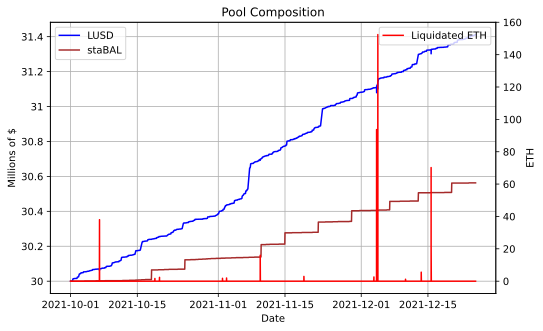

In [306]:
%config InlineBackend.figure_format='svg'

dates = np.arange(0, len(Pool), 72)
date_ticks = [Pool['date'][i] for i in dates]

fig1, ax1 = plt.subplots()
plot = ax1.plot(Pool['date'], Pool['LUSD'], color='blue')
plot = ax1.plot(Pool['date'], Pool['staBAL'], color='brown')
ax1.legend(('LUSD', 'staBAL'))
ax1.grid()
ax1.set_title('Pool Composition')
ax1.set_xlabel('Date')
ax1.set_ylabel('Millions of $')

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

fig1.set_size_inches(8, 5)

ax2 = ax1.twinx()

ax2.plot(Pool['date'], Data['LIQ col'], color='red')
ax2.legend(('Liquidated ETH',))
ax2.set_ylabel('ETH')

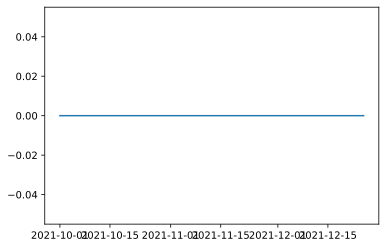

In [195]:
plt.plot(Data['date'], Data['LIQ col'])

The gap we see in the LUSD balance is a massive liquidation (most likely occuring during the recovery mode). Corresponding to what was stated by Liquity, liquidations increase the LP's total networh, which is seen by the jump in the LUSD balance after the received collateral ETH was traded back to LUSD.